In [1]:
%matplotlib notebook
import numpy as np
import pandas as pd
import seaborn as sns 
import matplotlib.pyplot as plt
sns.set()
from IPython import display
import time
from scipy.spatial import distance_matrix

# Data visualization

In [2]:
data_train = pd.read_csv('EMGaussian.data', sep=' ', header=None)
data_train.columns=['x','y']
data_test = pd.read_csv('EMGaussian.test', sep=' ', header=None)
data_test.columns=['x','y']


<IPython.core.display.Javascript object>


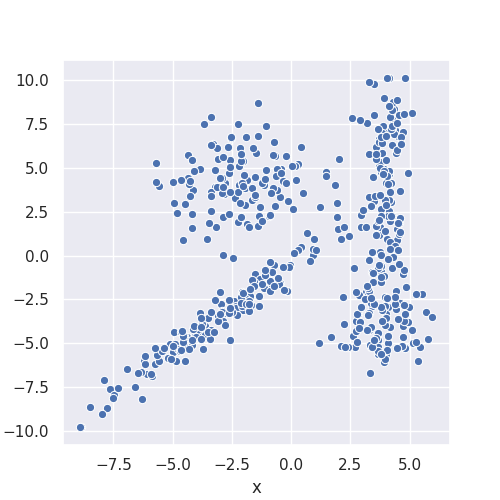

In [162]:
plt.figure(figsize=(5,5))
sns.scatterplot(x="x", y="y", data=data_train)

<IPython.core.display.Javascript object>


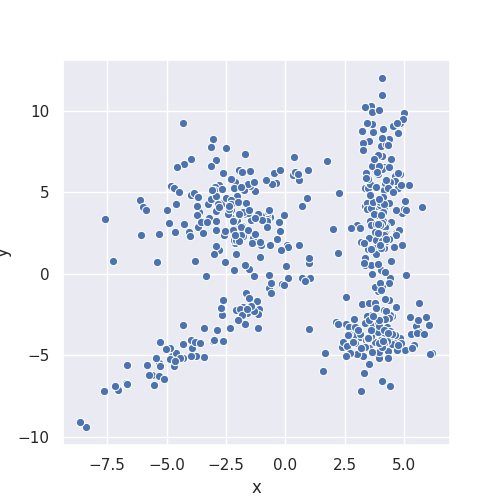

In [163]:
plt.figure(figsize=(5,5))
sns.scatterplot(x="x", y="y", data=data_test)

# K-means

In [5]:
def Jfunc(X, mu, z, k):
    J=0
    for i in range(k):
         J+=np.sum(np.power(np.linalg.norm(X[z==i]-mu[i,:],axis=1),2))
    return J

In [729]:
def kmeans(X, k, eps, display='all', timing=0.4):
    #initialization
    mu = X[np.random.randint(0, X.shape[0],k),:]
    convergence = False
    
    if display=='all':
        fig = plt.figure()
        ax = fig.add_subplot(111)
        palette =  ['red', 'blue', 'green', 'purple']
        plt.ion()
        ax.clear()
        ax.scatter(x=X[:,0], y=X[:,1], c='red')
        ax.scatter(x=mu[:,0],y=mu[:,1],c='black',marker='X')
        fig.canvas.draw()   # draw
        time.sleep(timing)    #sleep
        fig.show()
        
    j = np.inf

    while not(convergence):
        #optimize over z
        z = np.argmin(distance_matrix(X, mu),axis=1)
        
        if display=='all':
            ax.clear() # - Clear
            sns.scatterplot(x=X[:,0], y=X[:,1], hue=z, palette=palette)
            fig.canvas.draw()   # draw
            time.sleep(timing)    #sleep
        
        #optimize over mu
        for i in range(0,k):
            mu[i,:] = X[z==i].mean(axis=0)
            
        if display == 'all':
            ax.scatter(x=mu[:,0],y=mu[:,1],c='black',marker='X')
            fig.canvas.draw()   # draw
            time.sleep(timing) 
            
        #convergence evaluation
        if np.abs(j-Jfunc(X, mu, z, k))<eps:
            convergence = True
        else:
            j = Jfunc(X, mu, z, k)
        
        if display == 'all':
            fig.canvas.set_window_title('J: {}'.format(j))
    return mu, z

<IPython.core.display.Javascript object>


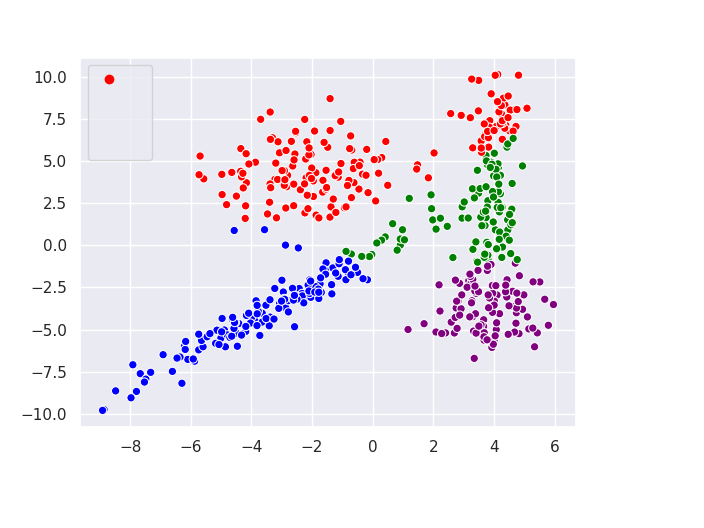

KeyboardInterrupt: 

In [768]:
mu, z = kmeans(data_train.values, 4, 0.1, display='all', timing=0.2)

In [686]:
def gaussian(x, mu, sigma):
    x = -1/2*(x-mu).T.dot(x-mu)/(sigma**2)
    if x>30:
        x = 30
    return np.exp(x)/sigma


In [739]:
cmaps_dic={'blue':'Blues',
           'red':'Reds',
           'green':'Greens',
           'purple':'Purples'}

In [797]:
class GaussianMixture():
    def __init__(self, X, k, covariance_mode, eps=0.1, display='all', timing=0.1):
        self.k = k
        self.X = X
        self.covariance_mode = covariance_mode
        mu,z = kmeans(X,k,0.1,display=None)
        self.z = pd.get_dummies(z).values
        self.eps = eps
        if covariance_mode == 'isotrope':
            self.sigmas = np.zeros(k)
        self.mus = np.zeros((self.X.shape[1],k))
        self.m_step()
    
        if display=='all':
            self.fig = plt.figure()
            self.ax = self.fig.add_subplot(111)
            self.palette =  ['red', 'blue', 'green', 'purple']
            plt.ion()
            self.ax.clear()
           
            time.sleep(timing)    #sleep
            
            grid, x_grid, y_grid = make_grid(data=self.X, step=100)
            self.x_grid = x_grid
            self.y_grid = y_grid
            self.grid = grid
            
            for i in range(k):
                self.ax.contourf(self.x_grid, self.y_grid, np.apply_along_axis(arr=self.grid,
                                       axis=1,
                                       func1d=lambda x:gaussian(x,
                                                                self.mus[:,i],
                                                                sigma=self.sigmas[i])).reshape(self.x_grid.shape),
                               alpha=0.3,
                               cmap =cmaps_dic[self.palette[i]])
            sns.scatterplot(x=X[:,0], y=X[:,1], hue=np.argmax(self.z,axis=1), palette=sns.color_palette("hls", k))
            self.ax.scatter(x=self.mus[0,:],y=self.mus[1,:],c='black',marker='X')
            self.fig.canvas.draw()   # draw
            self.fig.show()
   
    def m_step(self):
        self.pis = self.z.mean(axis=0)
        for i in range(k):
            self.mus[:,i] = (self.X*(self.z[:,i].reshape(-1,1))).sum(axis=0)/self.z[:,i].sum()
        for i in range(k):
            self.sigmas[i]=np.sqrt((self.X - self.mus[:,i]).dot((self.X-self.mus[:,i]).T).dot(np.diag(self.z[:,i])).trace()/np.diag(self.z[:,i]).sum())
        

<IPython.core.display.Javascript object>


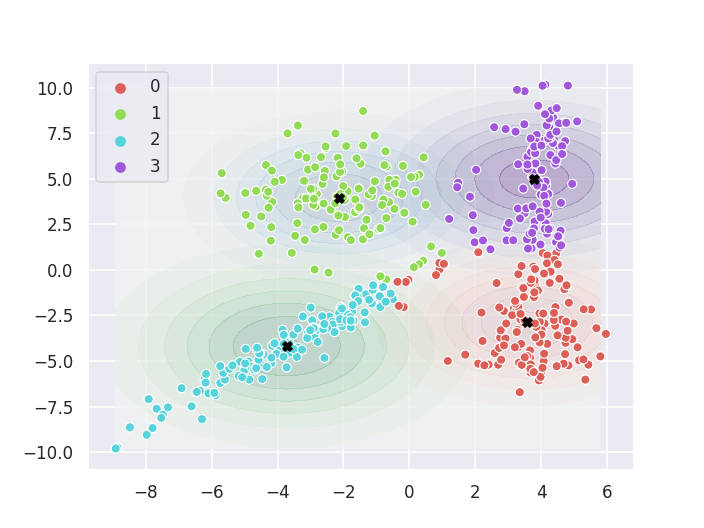

In [798]:
g = GaussianMixture(data_train.values, 4,'isotrope')